In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref")

# Load the base model
base_model = AutoModelForSequenceClassification.from_pretrained("InstaDeepAI/nucleotide-transformer-500m-human-ref", num_labels=1)

model_name = "kpps/mapq"
reloaded_model = PeftModel.from_pretrained(base_model, model_name)

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/390 [00:00<?, ?it/s]

EsmForSequenceClassification LOAD REPORT from: InstaDeepAI/nucleotide-transformer-500m-human-ref
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.decoder.weight      | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
esm.embeddings.position_ids | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


model.safetensors:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/24.3M [00:00<?, ?B/s]

In [ ]:
!curl https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/data/HG00096/sequence_read/SRR062634_1.filt.fastq.gz| gunzip | head -10000 >  SRR062634_1.filt.fastq.gz
!ls -lrth SRR062634*
!head SRR062634*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0 1849M    0  538k    0     0   213k      0  2:27:33  0:00:02  2:27:31  213k
curl: (23) Failure writing output to destination
-rw-r--r-- 1 root root 628K Feb 13 10:41 SRR062634_1.filt.fastq.gz
@SRR062634.1 HWI-EAS110_103327062:6:1:1092:8469/1
GGGTTTTCCTGAAAAAGGGATTCAAGAAAGAAAACTTACATGAGGTGATTGTTTAATGTTGCTACCAAAGAAGAGAGAGTTACCTGCCCATTCACTCAGG
+
@C'@9:BB:?DCCB5CC?5C=?5@CADC?BDB)B@?-A@=:=:@CC'C>5AA+*+2@@'-?>5-?C=@-??)'>>B?D@?*?A#################
@SRR062634.2 HWI-EAS110_103327062:6:1:1107:21105/1
ACCGTGAGCAATCAGCTGCCATCAACGTGGAGGTAAGACTCTCCACCTGCAAAAACATTACAACTTGCTGAAGGCTGAGATACTTGTTCGCACATTTTTA
+
FDEFF?DFEFE?BEEEEED=DB:DCEAEEB,CC=@B=5?B?CC5C?B+A??=>:CC<9-B2=@>-?:-<A@@A?9>*0<:'0%6,>:9&-:>?:>==B??
@SRR062634.3 HWI-EAS110_103327062:6:1:1110:17198/1
TAGATATTTTTGTTTTAACTGCTGTAGAAAATTAAGACATAAACTAAGAAATATCCCATGAAGGAATGAGTATACTGTTTCTACTTG

# Task
Classify DNA sequences from the "SRR062634.filt.fastq.gz" file using the `kpps/mapq` model, dynamically printing the classification ratios, and finally summarizing the total counts and ratios for each class.

## Extract Sequences and Classify

### Subtask:
Define a function to parse FASTQ records and yield sequences. Then, iterate through the sequences, tokenize each one, pass it through the 'kpps/mapq' model for classification, and update a running count for each class. The classification ratios will be printed dynamically after each classification.


**Reasoning**:
The subtask requires defining a function to parse FASTQ records, iterating through sequences, classifying them using the pre-loaded model, and dynamically printing classification ratios. This code block will perform all these steps.



**Reasoning**:
The previous `curl` command unzipped the file and then redirected the plain text output to a file named `SRR062634.filt.fastq.gz`. This caused a `BadGzipFile` error when `gzip.open` tried to read a non-gzipped file. I will update the `parse_fastq` function to open the file as a regular text file since it is not gzipped.



In [ ]:
from transformers import TrainingArguments, Trainer, EvalPrediction
from torch.utils.data import Dataset
import torch

batch_size=16

def parse_fastq(filepath):
    # Open as a regular text file since it's already unzipped
    with open(filepath, 'rt') as f:
        while True:
            header = f.readline().strip()
            if not header: # EOF
                break
            sequence = f.readline().strip()
            plus = f.readline().strip()
            quality = f.readline().strip()
            yield sequence

test_sequences = list(parse_fastq('SRR062634_1.filt.fastq.gz'))

class SequenceMAPQgt30Dataset(Dataset):
    def __init__(self, sequences, mapqs, tokenizer, max_length=30):
        self.sequences = sequences
        self.mapqs = mapqs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        mapq = self.mapqs[idx]

        # Tokenize the sequence
        # EsmTokenizer does not have encode_plus, it is directly callable
        encoding = self.tokenizer(
            sequence,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(mapq >= 30, dtype=torch.float)
        }

training_args = TrainingArguments(
    "mapq",
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps= 1,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=200,
    label_names=["labels"],
    dataloader_drop_last=True,
    report_to="none",
)

test_dataset = SequenceMAPQgt30Dataset(test_sequences, [1] * len(test_sequences), tokenizer)
reloaded_trainer = Trainer(
    model=reloaded_model,
    args=training_args,
    train_dataset=test_dataset,
    eval_dataset=test_dataset
)
reloaded_test_output = reloaded_trainer.predict(test_dataset)
reloaded_test_output

PredictionOutput(predictions=array([[0.15868638],
       [0.66269326],
       [0.51416683],
       ...,
       [1.0607395 ],
       [0.5928523 ],
       [0.4863787 ]], dtype=float32), label_ids=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), metrics={'test_loss': 0.22986769676208496, 'test_model_preparation_time': 0.0472, 'test_runtime': 27.8161, 'test_samples_per_second': 89.876, 'test_steps_per_second': 5.644})

In [ ]:
sum(reloaded_test_output.predictions<0.5), sum(reloaded_test_output.predictions>0.5)

(array([1547]), array([949]))

<Axes: ylabel='Count'>

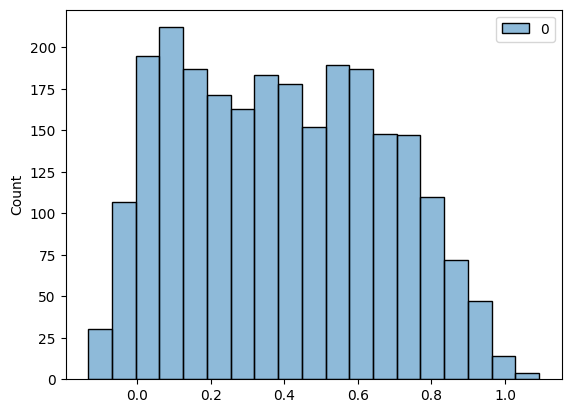

In [ ]:
import seaborn as sns
sns.histplot(reloaded_test_output.predictions)